In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import collections

# Data Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/2022Projects/异常检测/fraudData"

creditcard.csv	imbalancedFraudDF.csv  IpAddress_to_Country.csv


In [5]:
creditcardDF = pd.read_csv('/content/drive/MyDrive/laioffer/2022Projects/异常检测/fraudData/creditcard.csv') 
creditcardDF.head()#all numerical

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#Distribution of the label data
creditcardDF['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
492 / (284315  + 492) 

0.001727485630620034

less than 0.2%

In [9]:
creditcardDF.shape

(284807, 31)

In [10]:
creditcardDF.isna().sum()#null checking

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


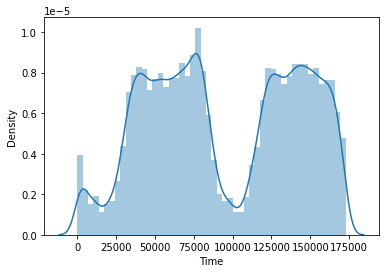

In [11]:
sns.distplot(creditcardDF['Time'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


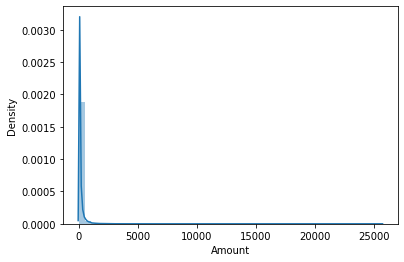

In [12]:
sns.distplot(creditcardDF['Amount'])

In [13]:
#log tranform
creditcardDF['Amount'] = np.log(creditcardDF['Amount'] + 1)
creditcardDF['Time'] = np.log(creditcardDF['Time'] + 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


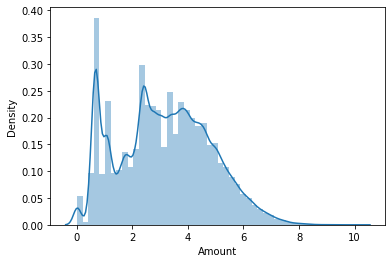

In [14]:
sns.distplot(creditcardDF['Amount'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


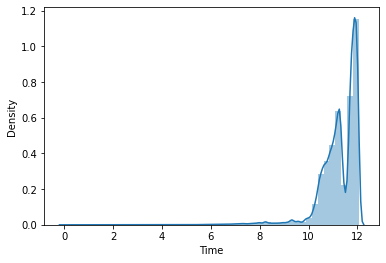

In [15]:
sns.distplot(creditcardDF['Time'])

In [16]:
normal = creditcardDF[creditcardDF['Class'] == 0]
anomaly = creditcardDF[creditcardDF['Class'] == 1] 

In [17]:
normal.shape

(284315, 31)

In [18]:
anomaly.shape

(492, 31)

In [19]:
train, small_normal = train_test_split(normal, test_size=0.2, random_state=0) #80%
normal_valid, normal_test = train_test_split(small_normal, test_size=0.5, random_state=0) #valid和test各10%
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)

validation = pd.concat([normal_valid, anomaly_valid])#include both good and bad, cross validation data in our text
test = pd.concat([normal_test, anomaly_test])#include both good and bad

In [20]:
validation.shape

(28677, 31)

In [21]:
test.shape

(28678, 31)

In [22]:
train = train.drop(columns = ['Class']).reset_index(drop= True)#no need of label in train data, drop it
train.shape

(227452, 30)

In [23]:
featureNames = list(train.columns.values)#feature names only, no label
valFeatures = validation[featureNames].reset_index(drop= True)#feature df only, no label
testFeatures = test[featureNames].reset_index(drop= True)#feature df only, no label

valLabel = validation['Class']#label df only
testLabel = test['Class']#label df only

In [24]:
valFeatures.shape

(28677, 30)

In [25]:
valLabel.value_counts()

0    28431
1      246
Name: Class, dtype: int64

In [26]:
testLabel.value_counts()

0    28432
1      246
Name: Class, dtype: int64

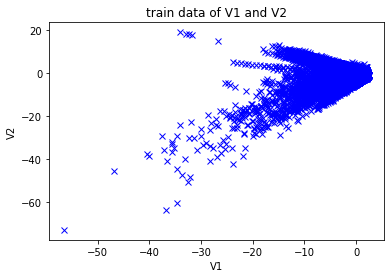

In [27]:
plt.figure()
plt.title("train data of V1 and V2")#may contain outliers
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx")
plt.show()

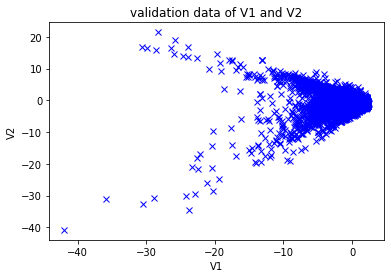

In [28]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

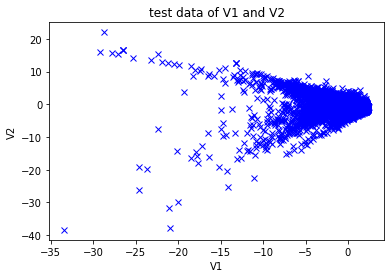

In [29]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

In [30]:
#find parameter(mean, covaraince) for each col/feature in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

In [ ]:
# def read_dataset(filePath, delimiter=','):
#     return genfromtxt(filePath, delimiter=delimiter)

#find parameter for each col/feature in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


In [31]:
mu, sigma = estimateGaussian(train)

model training

In [32]:
#generate The probability density function/curve/surface/model for multivariate_normal given mean and cov 
#allow_singular: Whether to allow a singular covariance matrix. (Default: False); multivariate_normal needs inverse of cov
model = multivariate_normal(mean=mu, cov=sigma, allow_singular = True)#surface hat p(x)

In [33]:
pdfVal = model.pdf(valFeatures)
print(max(pdfVal))#too small, can not differentiate
print(min(pdfVal))

p_val = model.logpdf(valFeatures)#Log of the pdf first, then apply to features, to change the magnitude of prob
print(max(p_val))#
print(min(p_val))

3.9360226892478286e-12
0.0
-26.260850372210484
-7554.270217704675


In [35]:
p = model.logpdf(train)
print(p.shape, max(p), min(p))
print((p_val.shape))

(227452,) -25.962828922259945 -18323.670439537575
(28677,)


In [36]:
print(p_val)
print(p_val < -500)

[  -31.28574735   -34.94205051   -27.79402451 ... -5175.93656039
 -4545.5057626    -29.7152192 ]
[False False False ...  True  True False]


Finding the best threshold from validation set

In [37]:
scores = []
p_val = model.logpdf(valFeatures)#Log of the pdf

# thresholds = np.linspace(-1000, -10,150)
thresholds = np.linspace(min(p_val), max(p_val),200)#generate all candidate threshold, epsilon

#step 2:  find optimal threshold: bestThreshold
for threshold in thresholds:
  y_pred = (p_val < threshold).astype(int)# list of 0 and 1 #predict by calculating the probability
  #calculate recall, precision and f1 for each (truth, pred) pair, corresponding to that threshold
  scores.append([recall_score(valLabel, y_pred),
                 precision_score(valLabel, y_pred),
                 f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)
maxIndex = scores[...,2].ravel().argmax()#maxIndex of the 3rd column (f1_score) #193, #.ravel return a flattened array
bestThreshold = thresholds[maxIndex]
print(scores.shape)#each row is a pair of (recall, precision, f1) corresponding to a threshold

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(200, 3)


In [44]:
scores[maxIndex]

array([0.78861789, 0.7080292 , 0.74615385])

In [39]:
print(maxIndex)
print(bestThreshold)

193
-253.2360071762041


In [40]:
np.mean(train.iloc[:,1])

0.0052467554200621574

In [41]:
mu[1]

0.0052467554200621574

In [42]:
print(mu)

Time      11.252384
V1         0.005247
V2        -0.005416
V3         0.010293
V4        -0.008144
V5         0.004281
V6         0.001813
V7         0.010354
V8        -0.001103
V9         0.006351
V10        0.009573
V11       -0.007736
V12        0.009943
V13        0.001084
V14        0.010816
V15        0.001082
V16        0.007216
V17        0.012364
V18        0.003412
V19       -0.001811
V20       -0.001092
V21       -0.001302
V22       -0.000354
V23        0.000209
V24        0.000288
V25        0.000375
V26        0.000457
V27       -0.000509
V28       -0.000119
Amount     3.152259
dtype: float64


In [43]:
#performance on test data
#step 3: prediction on test data
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold

f1_score(testLabel, y_pred_test, average = "binary")

0.7401574803149606

In [45]:
y_pred_test

array([False, False, False, ...,  True, False,  True])

In [53]:
#index of predicted outliers in test data
predoutliersTest = np.asarray(np.where(y_pred_test))
len(predoutliersTest[0]) #number of outliers in test set

262

In [54]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8267,  8452,  8611,  8677,
         8936,  8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657,
        11224, 12205, 13539, 13935, 14050, 14573, 14579, 14802, 14869,
        15740, 16061, 16888, 17322, 17663, 19352, 19902, 20680, 20800,
        21748, 22366, 22552, 22859, 23217, 23456, 23742, 24639, 24819,
        25654, 25678, 26035, 27282, 27293, 27314, 27587, 27723, 28117,
        28178, 28396, 28432, 28433, 28434, 28435, 28436, 28437, 28438,
        28440, 28443, 28444, 28445, 28446, 28447, 28449, 28450, 28453,
        28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462,
        28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471,
        28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28484,
        28486, 28487, 28490, 28492, 28493, 28494, 28496, 28497, 28498,
      

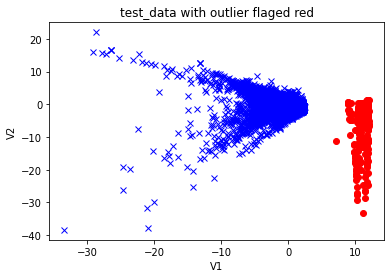

In [49]:
#outliers identified on test data feature column V1 V2
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(testFeatures.iloc[:, 1],testFeatures.iloc[:,2],"bx")#plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")#re-plot the outliers as red dots
plt.show()

model evaluation

In [56]:
# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_pred_test)))
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9953971685612665
roc_auc_score is: : 0.8808124705473279
f1_score is: : 0.7401574803149606
confusion_matrix is: 
        pred_0  pred_1
true_0   28358      74
true_1      58     188
recall = 0.7642276422764228
precision = 0.7175572519083969


# Supervised learning


use the output prob as an additional input feature of the supervised learning model, and see if it improved the model performance

Hyperparameters:

1.Number of estimators: n_estimators refers to the number of base estimators or trees in the ensemble, i.e. the number of trees that will get built in the forest. This is an integer parameter and is optional. The default value is 100.

2.Max samples: max_samples is the number of samples to be drawn to train each base estimator. If max_samples is more than the number of samples provided, 
all samples will be used for all trees. The default value of max_samples is 'auto'. If 'auto', then max_samples=min(256, n_samples)

3.Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. 
This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. 
If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.

4.Max features: All the base estimators are not trained with all the features available in the dataset. It is the number of features to 
draw from the total features to train each base estimator or tree.The default value of max features is one.


In [59]:
IFModel = IsolationForest(random_state=888, contamination = 0.01, n_estimators = 200, max_features = 2).fit(train)
IFModel

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01, max_features=2, n_estimators=200,
                random_state=888)

In [61]:
# convert 1/-1 to 0/1 for f1 calculation
def convert(x):
  if x == 1:
    return 0
  else:
    return 1
pred = IFModel.predict(testFeatures) #1 for inliers, -1 for outliers.
pred2 = list(map(convert, pred))

In [63]:
counter=collections.Counter(pred2)
print(counter)
f1_score(testLabel, pred2, average = "binary")#0.48 when added parameters

Counter({0: 28296, 1: 382})


0.5063694267515924